# **Notebook 1**: Data Visualisation

In [1]:
import importlib
import subprocess

libraries = {
    "pillow": "PIL",
    "folium": "folium",
    "matplotlib": "matplotlib",
}

COLORS = {
    "green": "\033[92m",
    "red": "\033[91m",
    "end": "\033[0m"
}

for pip_name, import_name in libraries.items():
    if importlib.util.find_spec(import_name) is None:
        print(f"{COLORS['red']}[!] {pip_name} is not installed. Attempting to install... {pip_name}'{COLORS['end']}")

        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", pip_name])
            print(f"{COLORS['green']}[+] Successfully installed {pip_name}.{COLORS['end']}")
        except subprocess.CalledProcessError:
            print(f"{COLORS['red']}[!] Failed to install {pip_name}. Please install it manually.{COLORS['end']}")
    else:
        print(f"{COLORS['green']}[+] {pip_name} is installed.{COLORS['end']}")

[+] pillow is installed.
[+] folium is installed.
[+] matplotlib is installed.


In [2]:
# group_5_members = ["AlisonAttard", "BenTaliana", "MichaelFarrugia", "MelatAssefa"]
# ! uncomment the line above when everyone has added their images ^^^

group_5_members = ["MichaelFarrugia"] # again, this is temporary

In [3]:
import os

all_image_paths = [os.path.join(member, "images", img) for member in group_5_members for img in os.listdir(os.path.join(member, "images"))]
coco_export_paths = [os.path.join(member, f"{member}_COCO_export.json") for member in group_5_members]
json_export_paths = [os.path.join(member, f"{member}_JSON_export.json") for member in group_5_members]

## **Dataset Annotation Statistics and Checks**

In [4]:
num_images_per_member = {member: len([img for img in all_image_paths if img.startswith(os.path.join(member, "images"))]) for member in group_5_members}
total_images = len([img for img in all_image_paths])

In [5]:
from json import loads

for coco_export_path in coco_export_paths:
    with open(coco_export_path, "r") as f:
        coco_data = loads(f.read())

    member_name = coco_export_path.split(os.sep) [0]

    assert len(coco_data ["images"]) == num_images_per_member[member_name], f"Missing annotations for {member_name}: expected {num_images_per_member[member_name]}, found {len(coco_data ['images'])}"

optionally eventually we can do the statistics per member but i think that might be pointless

In [6]:
from collections import defaultdict

sign_type_statistics = defaultdict(int)
viewing_angle_statistics = defaultdict(int)
mounting_type_statistics = defaultdict(int)
sign_condition_statistics = defaultdict(int)
sign_shape_statistics = defaultdict(int)

Most signs have an expected sign shape. For our dataset, we expect:
- "Stop" signs to be octagonal
- "No Entry (One Way)" signs to be circular
- "Pedestrian Crossing (Zebra Crossing)" signs to be square
- "Roundabout Ahead" signs to be triangular
- "No Through Road (T-Sign)" signs to be square
- "Blind-Spot Mirrors (Convex Mirrors)" signs to be circular

In [7]:
def expect_sign_shape(sign_type: str, sign_shape: str, img_filename: str):
    expected_shapes = {
        "Stop": "Octagonal",
        "No Entry (One Way)": "Circular",
        "Pedestrian Crossing": "Square",
        "Roundabout Ahead": "Triangular",
        "No Through Road (T-Sign)": "Square",
        "Blind-Spot Mirror (Convex)": "Circular"
    }

    if expected_shapes [sign_type] != sign_shape:
        print(f"{COLORS['red']}[!] Sign shape mismatch for '{img_filename}': expected '{expected_shapes [sign_type]}', found '{sign_shape}'{COLORS['end']}. Double check to make sure this annotation is accurate")

In [8]:
for json_export_path in json_export_paths:
    with open(json_export_path, "r") as f:
        json_data = loads(f.read())

    member_name = json_export_path.split(os.sep) [0]

    assert len(json_data) == num_images_per_member[member_name], f"Missing annotations for {member_name}: expected {num_images_per_member[member_name]}, found {len(json_data ['images'])}"
    
    # the annotated attribute type for viewing angle should match what is seen on the filename
    for json_entry in json_data:
        filename = json_entry ["file_upload"].split("-") [1]

        annotated_items = [
            item
            for annotation in json_entry ["annotations"]
            for item in annotation ["result"]
        ]


        annotated_view_angle = list(filter(lambda item: item.get("from_name") == "view_angle", annotated_items)) [0] ["value"] ["choices"] [0]

        filename_view_angle = filename.split(".jpg") [0].split("_") [-1]
        assert annotated_view_angle == filename_view_angle, f"View angle mismatch for {member_name} in image {json_entry ['file_upload']}: expected {filename_view_angle}, found {annotated_view_angle}"

        viewing_angle_statistics [annotated_view_angle] += 1
        
        if annotated_view_angle != "Front":
            continue

        annotated_sign_type = list(filter(lambda item: item.get("from_name") == "sign_type", annotated_items)) [0] ["value"] ["rectanglelabels"] [0]

        annotated_mounting_type = list(filter(lambda item: item.get("from_name") == "mounting", annotated_items)) [0] ["value"] ["choices"] [0]

        annotated_sign_condition = list(filter(lambda item: item.get("from_name") == "condition", annotated_items)) [0] ["value"] ["choices"] [0]

        annotated_sign_shape = list(filter(lambda item: item.get("from_name") == "sign_shape", annotated_items)) [0] ["value"] ["choices"] [0]
        
        expect_sign_shape(annotated_sign_type, annotated_sign_shape, filename)

        sign_type_statistics [annotated_sign_type] += 1
        mounting_type_statistics [annotated_mounting_type] += 1
        sign_condition_statistics [annotated_sign_condition] += 1
        sign_shape_statistics [annotated_sign_shape] += 1

### Bar Charts for Dataset Statistics

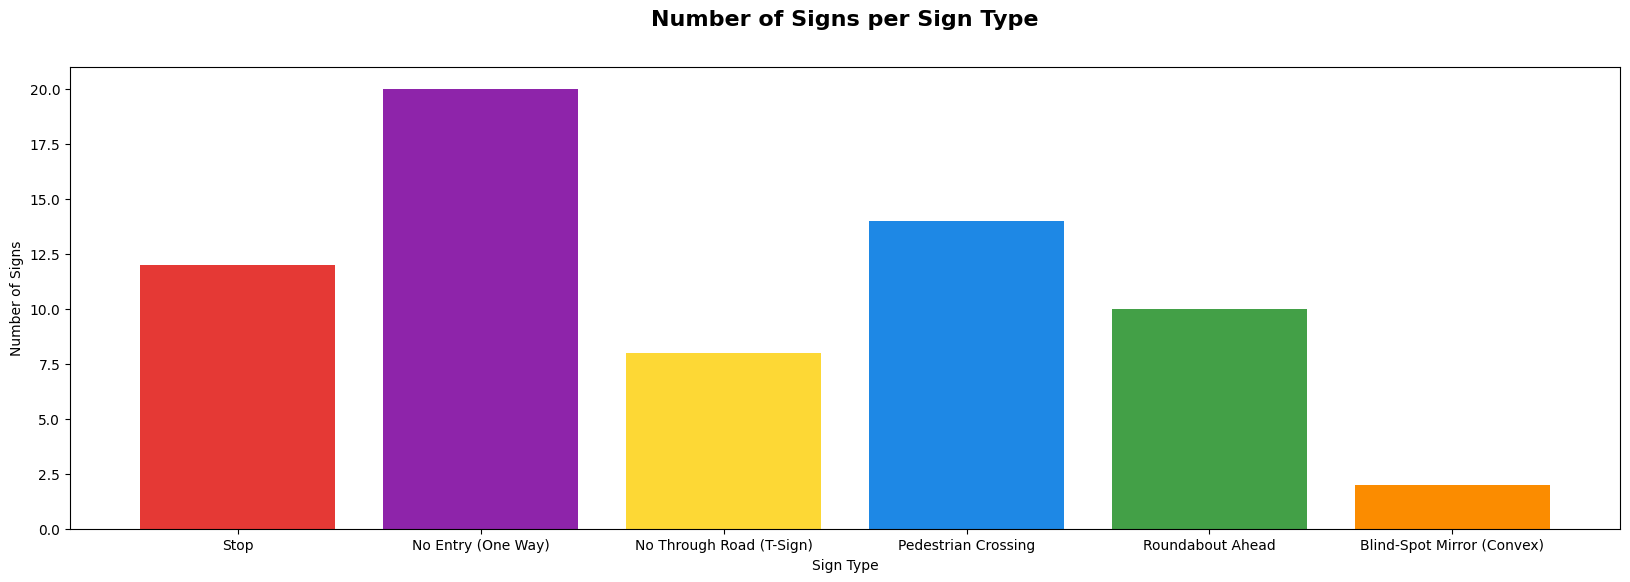

In [9]:
import matplotlib.pyplot as plt

SIGN_COLORS = ["#E53935", "#8E24AA", "#FDD835", "#1E88E5", "#43A047", "#FB8C00"] # these colours were in the .xml document used for the labeling interface

plt.figure(figsize = (20, 6))
plt.bar(sign_type_statistics.keys(), sign_type_statistics.values(), color = SIGN_COLORS)
plt.xlabel("Sign Type")
plt.ylabel("Number of Signs")
plt.title("Number of Signs per Sign Type", fontsize = 16, fontweight = "bold", pad = 30)
plt.show()

**note from mike here**: in some of my images, when the signs were right against each other, and i couldnt capture the back side of a sign, i didnt take the "back angle". for example, when a stop sign was attached against a no entry sign, i only took the front of the stop sign, and the side angle of the no entry sign

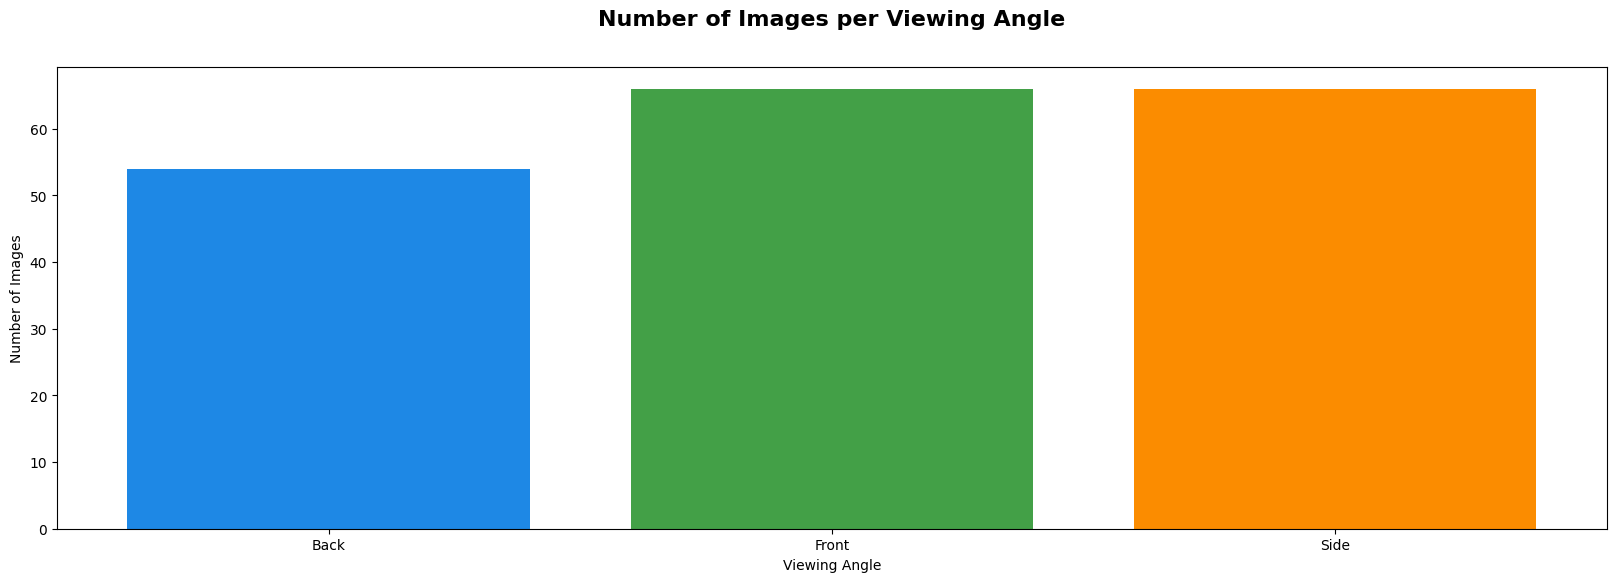

In [10]:
plt.figure(figsize = (20, 6))
plt.bar(viewing_angle_statistics.keys(), viewing_angle_statistics.values(), color = ["#1E88E5", "#43A047", "#FB8C00"])
plt.xlabel("Viewing Angle")
plt.ylabel("Number of Images")
plt.title("Number of Images per Viewing Angle", fontsize = 16, fontweight = "bold", pad = 30)
plt.show()

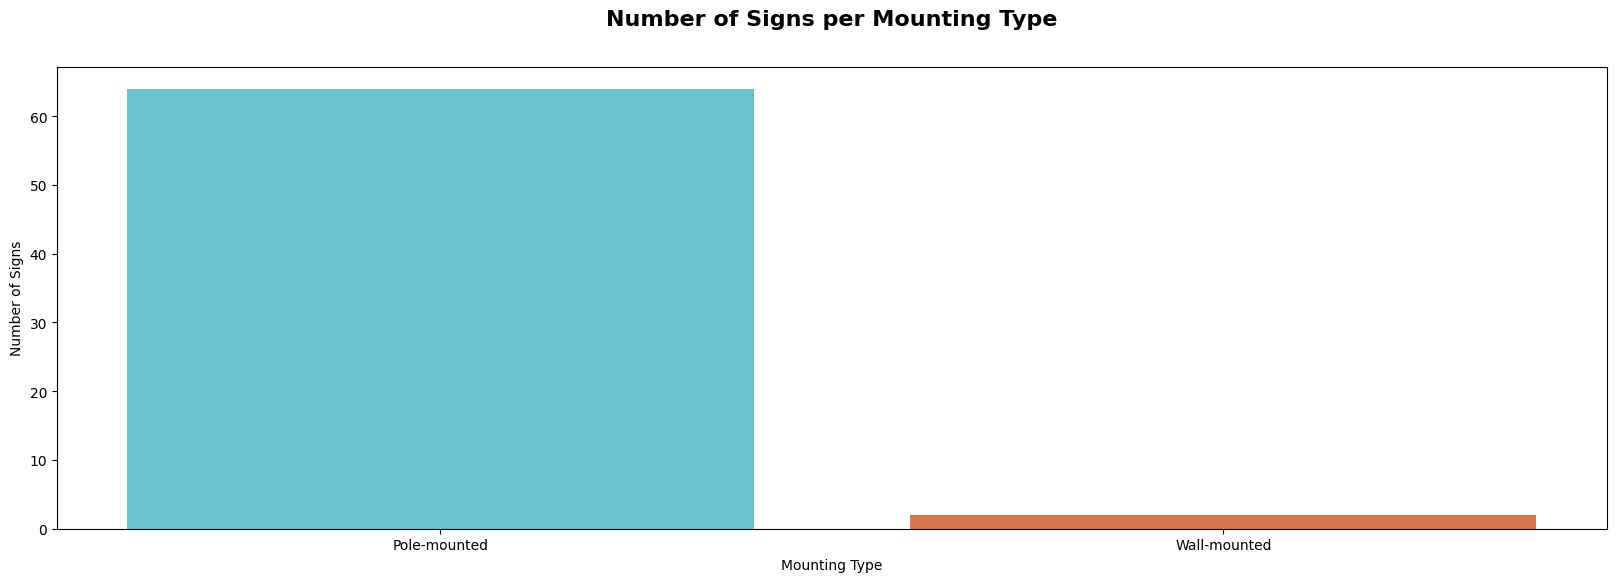

In [11]:
plt.figure(figsize = (20, 6))
plt.bar(mounting_type_statistics.keys(), mounting_type_statistics.values(), color = ["#6AC3CD", "#D8784B"])
plt.xlabel("Mounting Type")
plt.ylabel("Number of Signs")
plt.title("Number of Signs per Mounting Type", fontsize = 16, fontweight = "bold", pad = 30)
plt.show()

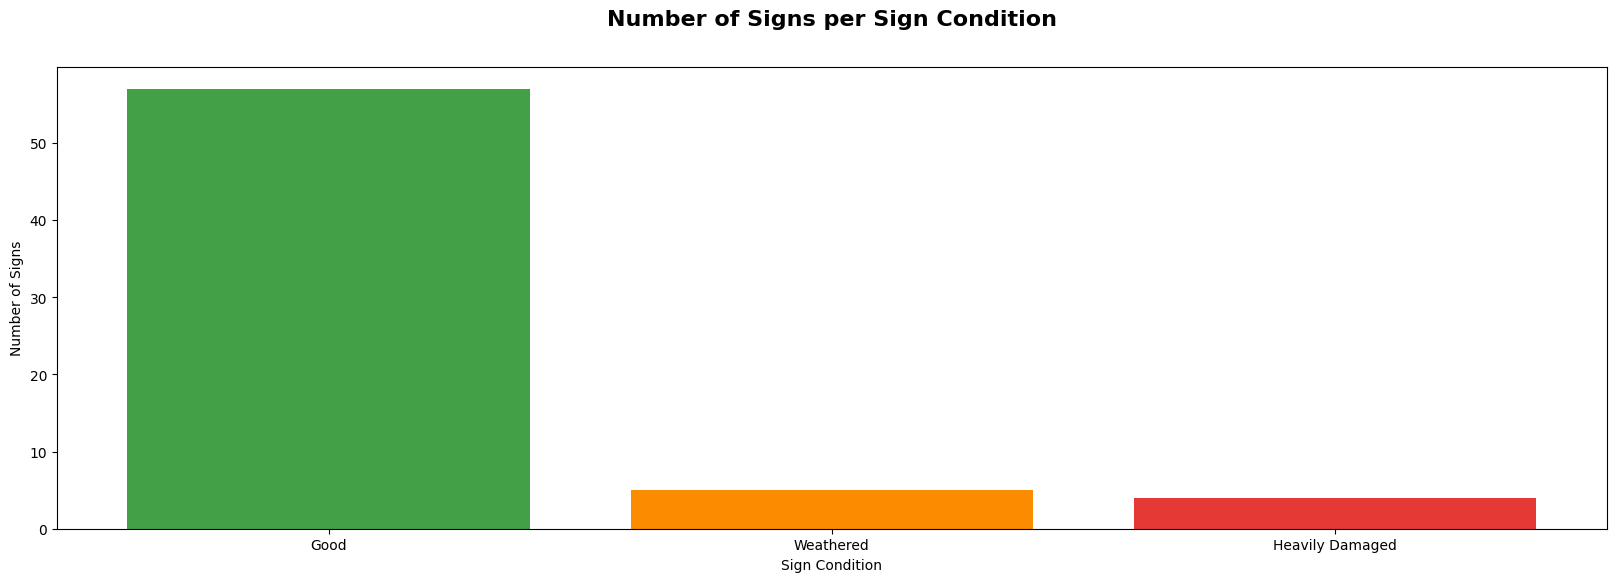

In [12]:
plt.figure(figsize = (20, 6))
plt.bar(sign_condition_statistics.keys(), sign_condition_statistics.values(), color = ["#43A047", "#FB8C00", "#E53935"])
plt.xlabel("Sign Condition")
plt.ylabel("Number of Signs")
plt.title("Number of Signs per Sign Condition", fontsize = 16, fontweight = "bold", pad = 30)
plt.show()

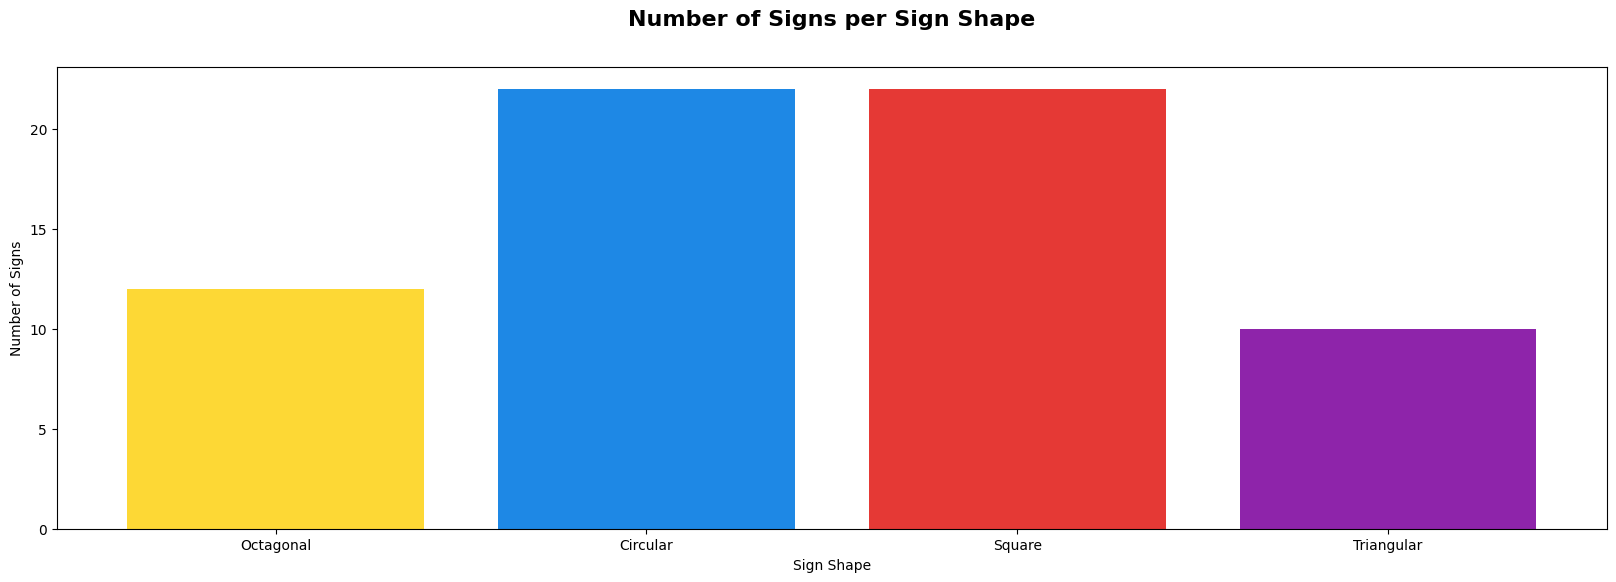

In [13]:
plt.figure(figsize = (20, 6))
plt.bar(sign_shape_statistics.keys(), sign_shape_statistics.values(), color = ["#FDD835", "#1E88E5", "#E53935", "#8E24AA"])
plt.xlabel("Sign Shape")
plt.ylabel("Number of Signs")
plt.title("Number of Signs per Sign Shape", fontsize = 16, fontweight = "bold", pad = 30)
plt.show()

## **Dataset Visualisation on a Map**

In [14]:
from PIL import Image
from PIL.ExifTags import TAGS, GPSTAGS

num_images_per_member = {member: len([img for img in all_image_paths if img.startswith(os.path.join(member, "images")) and img.endswith("_Front.jpg")]) for member in group_5_members}
total_images = len([img for img in all_image_paths if img.endswith("_Front.jpg")])

def get_gps_tags(image_path):
    image = Image.open(image_path)
    exif_data = image._getexif()

    for tag, value in exif_data.items():
        tag_name = TAGS.get(tag, tag)

        if tag_name == "GPSInfo":
            gps_data = {}

            for gps_tag in value:
                gps_tag_name = GPSTAGS.get(gps_tag, gps_tag)
                gps_data [gps_tag_name] = value [gps_tag]

            return gps_data

In [15]:
def convert_dms_to_decimal(dms_coordinate):
    deg, minute, sec = dms_coordinate

    deg = float(deg)
    minute = float(minute) / 60
    sec = float(sec) / 3600
    
    return deg + minute + sec

In [16]:
def read_img_and_get_coords(image_path):
    img_gps = get_gps_tags(image_path)
    img_latitude = img_gps ["GPSLatitude"]
    img_longitude = img_gps ["GPSLongitude"]
    
    return (convert_dms_to_decimal(img_latitude), convert_dms_to_decimal(img_longitude))

In [17]:
def get_time_tags(image_path):
    image = Image.open(image_path)
    exif_data = image._getexif()

    for tag, value in exif_data.items():
        tag_name = TAGS.get(tag, tag)

        if tag_name == "DateTimeOriginal":
            return value

In [18]:
from datetime import datetime

def format_date(date_string):
    dt = datetime.strptime(str(date_string), "%Y:%m:%d %H:%M:%S")
    return dt.strftime("%d/%m/%Y %H:%M")

In [19]:
def read_img_and_get_datetime(image_path):
    img_time = get_time_tags(image_path)

    return format_date(img_time)

In [20]:
from folium import Map

first_img_coords = read_img_and_get_coords(all_image_paths [0])

map = Map(location = first_img_coords, zoom_start = 12)

In [21]:
from folium import Marker
from re import sub

for img_path in all_image_paths:
    img_name = img_path.split("images\\") [1].split(".jpg") [0]

    # no need to plot all angles of the same sign
    if not img_name.endswith("Front"):
        continue
    
    img_coords = read_img_and_get_coords(img_path)

    img_id = img_name.split("_Front") [0].split("_") [1]
    member_name = img_name.split("_") [0]

    img_datetime = read_img_and_get_datetime(img_path)

    Marker(location = [img_coords [0], img_coords [1]], popup = f"{sub(r'(?<!^)(?=[A-Z])', ' ', member_name)} Sign {img_id} taken at {img_datetime}").add_to(map)

Note that on the map below, not all signs will appear due to the slight misprecision in GPS coordinates - some GPS coordinates did not capture the "seconds" and thus appear to be overlapping on the map.

In [22]:
map

## **Dataset Statistics**